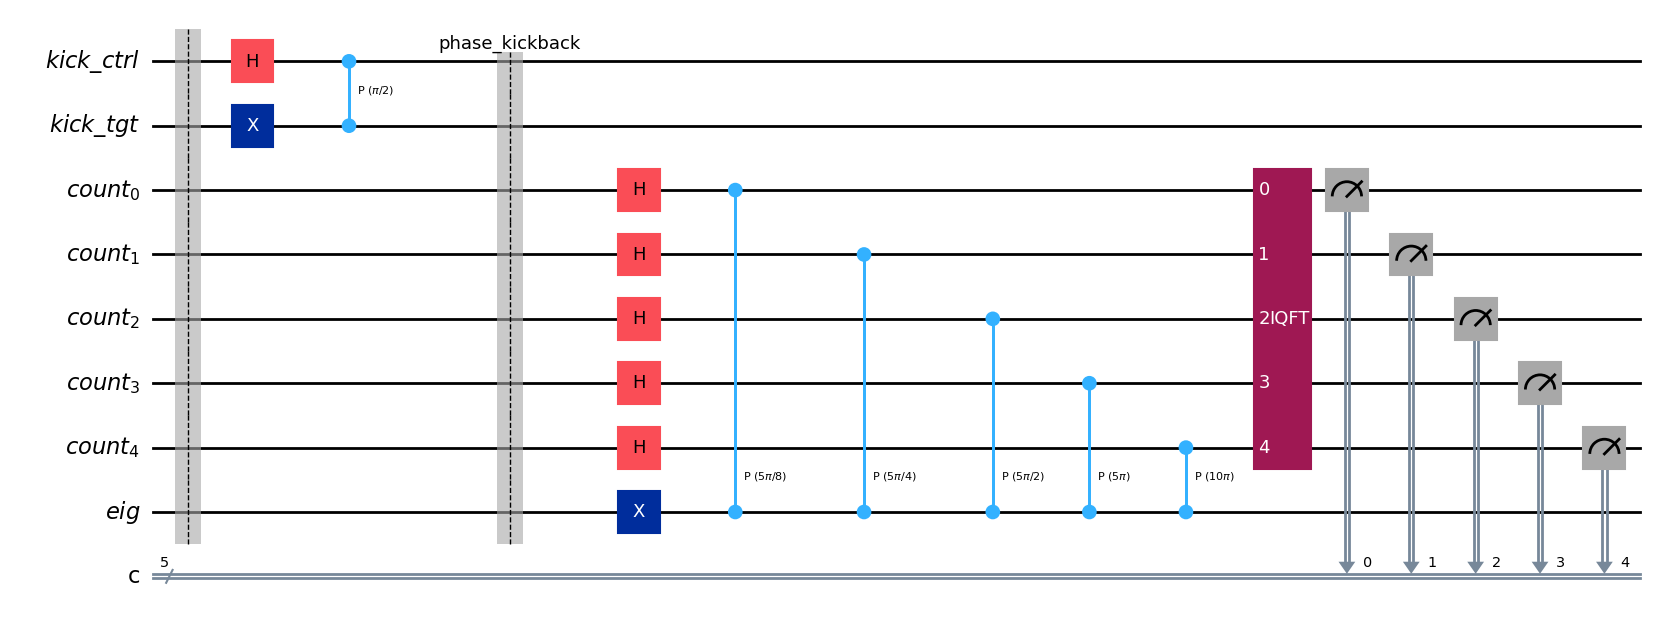

In [2]:
# If needed, install first:
# %pip install qiskit qiskit-aer

from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT

# ----- tweak these if you like -----
phi_kick = 1/4          # phase for the kickback demo (φ = 0.25 → π/2)
phi_qpe  = 5/16         # phase encoded by U in QPE (exact in 5 bits)
t_bits   = 5            # number of counting qubits
svg_path = "/mnt/data/estimate-phase-with-kickback.svg"
# -----------------------------------

def apply_controlled_power(qc: QuantumCircuit, ctrl_q, tgt_q, phi: float, power: int):
    """Apply controlled-U^(2^power) where U = Rz(2πφ) on target."""
    angle = 2 * pi * phi * (2**power)
    qc.cp(angle, ctrl_q, tgt_q)

# Build one circuit that contains both the phase-kickback demo and the QPE
kick_ctrl = QuantumRegister(1, "kick_ctrl")
kick_tgt  = QuantumRegister(1, "kick_tgt")
count     = QuantumRegister(t_bits, "count")
eig       = QuantumRegister(1, "eig")
c_reg     = ClassicalRegister(t_bits, "c")

qc = QuantumCircuit(kick_ctrl, kick_tgt, count, eig, c_reg, name="Estimate phase with kickback")

# ---------------------------
# Section A: Phase Kickback
# ---------------------------
qc.barrier()
# Prepare |+> on control, |1> on target
qc.h(kick_ctrl[0])
qc.x(kick_tgt[0])
# Controlled phase U = Rz(2π φ_kick) on target → phase kicks back to control
qc.cp(2 * pi * phi_kick, kick_ctrl[0], kick_tgt[0])
qc.barrier(label="phase_kickback")

# ---------------------------
# Section B: QPE for U = Rz(2π φ_qpe)
# ---------------------------
# Prepare eigenstate |1> on target
qc.x(eig[0])

# Uniform superposition on counting register
for k in range(t_bits):
    qc.h(count[k])

# Controlled powers U^(2^k)
for k in range(t_bits):
    apply_controlled_power(qc, count[k], eig[0], phi_qpe, power=k)

# Inverse QFT on counting register (use library IQFT)
iqft = QFT(num_qubits=t_bits, do_swaps=True, inverse=True, name="IQFT")
qc.append(iqft, count[:])

# Measure counting register
qc.measure(count, c_reg)

# Save SVG (Matplotlib drawer chooses format from filename extension)
qc.draw(output="mpl")
#qc.draw(output="mpl", filename=svg_path)
#print(f"Saved SVG to {svg_path}")


In [3]:
with open("/mnt/data/estimate-phase-with-kickback.svg") as f:
    svg_text = f.read()
print(svg_text[:2000])  # show first ~2000 characters


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/estimate-phase-with-kickback.svg'